#### Algoritmo Genetico 

#### Librerias:

In [240]:
import random
import itertools
import numpy as np
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style("darkgrid")
plt.style.use('dark_background')
%matplotlib inline

#### Parametros

In [241]:
TAMANIO_POBLACION = 4
LONGITUD_CROMOSOMA = 5
TASA_MUTACION = 0.1
TASA_CRUCE = 0.85
GENERACIONES = 10
X_MIN = -10
X_MAX = 10
Y_MIN = 0
Y_MAX = 20
TAMANIO_TORNEO = 3  # tamaño del torneo

#### Aptitud (7.7 + 0.15 * x + 0.22 * y - 0.05 * (x ** 2) - 0.016 * (y ** 2) - 0.007 * x * y)

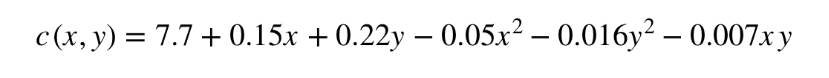

In [242]:
def binario_a_decimal_x(cromosoma):
    decimal = int(cromosoma, 2)
    x = X_MIN + decimal * (X_MAX - X_MIN) / ((2 ** LONGITUD_CROMOSOMA) - 1)
    return x

In [243]:
def binario_a_decimal_y(cromosoma):
    decimal = int(cromosoma, 2)
    x = Y_MIN + decimal * (Y_MAX - Y_MIN) / ((2 ** LONGITUD_CROMOSOMA) - 1)
    return x

In [244]:
def aptitud(individuo):

    cromosoma_x, cromosoma_y = individuo[0], individuo[1]

    x = binario_a_decimal_x(cromosoma_x)
    y = binario_a_decimal_y(cromosoma_y)
    
    return 7.7 + 0.15 * x + 0.22 * y - 0.05 * (x ** 2) - 0.016 * (y ** 2) - 0.007 * x * y

#### Inicializar la población

In [245]:
def inicializar_poblacion(tamanio_poblacion, longitud_cromosoma):
    poblacion_xy = []
    for tp in range(tamanio_poblacion):
        cromosoma_x = ""
        cromosoma_y = ""
        for lc in range(longitud_cromosoma):
            #  se crean los cromosomas alelo por alelo en forma aleatoria
            #  hasta completar toda la poblacion
            cromosoma_x = cromosoma_x + str(random.randint(0, 1))
            cromosoma_y = cromosoma_y + str(random.randint(0, 1))
        poblacion_xy.append((cromosoma_x, cromosoma_y))
    return poblacion_xy # tupla con los valores de las soluciones

#### Seleccion por ruleta

In [246]:
def seleccion_ruleta(poblacion, aptitud_total):
    probabilidades = []
    for cromosoma_X, cromosoma_y in poblacion: # tupla con valores cromosoma_x, cromosoma_y
        prob = aptitud((cromosoma_X, cromosoma_y)) / aptitud_total
        probabilidades.append(prob)

    probabilidades_acumuladas = []
    suma = 0
    for prob in probabilidades:
        suma = suma + prob
        probabilidades_acumuladas.append(suma)

    r = random.random()
    # despues de generar un numero aleatorio entre 0 y 1
    # se itera sobre la lista probabilidades_acumuladas
    # y se obtiene el indice (i) del cromosoma que selecciono para que forme parte de la nueva poblacion
    # tambien se obtiene el valor de probabilidad acumulada en la variable "acumulada"
    for i, acumulada in enumerate(probabilidades_acumuladas):
        if r <= acumulada:
            return poblacion[i] # devolvemos una de las tuplas

#### Selección por torneo

In [247]:
def seleccion_torneo(poblacion, tamanio_torneo=TAMANIO_TORNEO):
    progenitores = [] # lista de tuplas
    for _ in range(len(poblacion)):
        candidatos = random.sample(poblacion, tamanio_torneo)
        progenitor = max(candidatos, key=aptitud)  # se selecciona el mejor individuo del torneo
        progenitores.append(progenitor)
    return progenitores

#### Cruce monopunto con probabilidad de cruza pc = 0.92

In [248]:
def cruce_mono_punto(progenitor1, progenitor2, tasa_cruce): # Dos tuplas con progenitores
    if random.random() < tasa_cruce:

        punto_cruce_x = random.randint(1, len(progenitor1[0]) - 1)  # elijo aleatoriamente un punto de cruce
        punto_cruce_y = random.randint(1, len(progenitor1[1]) - 1)  # elijo aleatoriamente un punto de cruce

        descendiente1_x = progenitor1[0][:punto_cruce_x] + progenitor2[0][punto_cruce_x:]
        descendiente1_y = progenitor1[1][:punto_cruce_y] + progenitor2[1][punto_cruce_y:]
        descendiente2_x = progenitor2[0][:punto_cruce_x] + progenitor1[0][punto_cruce_x:]
        descendiente2_y = progenitor2[1][:punto_cruce_y] + progenitor1[1][punto_cruce_y:]

        descendiente1, descendiente2 = (descendiente1_x, descendiente1_y), (descendiente2_x, descendiente2_y)

    else:
        descendiente1, descendiente2 = progenitor1, progenitor2
    return descendiente1, descendiente2

#### mutacion

In [249]:
def mutacion(cromosoma, tasa_mutacion): # recibe tupla

    cromosoma_x_mutado = ""
    cromosoma_y_mutado = ""

    for bit in cromosoma[0]:  # primer valor de la tupla, recorremos cada alelo
        if random.random() < tasa_mutacion:
            # se produce la mutacion de un alelo si es que el numero aleatorio generado
            # es inferior que tasa_mutacion tambien llamado "pm" (prob.de mutacion)
            cromosoma_x_mutado = cromosoma_x_mutado + str(int(not int(bit)))
        else:
            cromosoma_x_mutado = cromosoma_x_mutado + bit

    for bit in cromosoma[1]:  # aqui se itera cada gen del cromosoma recibido
        if random.random() < tasa_mutacion:
            # se produce la mutacion de un alelo si es que el numero aleatorio generado
            # es inferior que tasa_mutacion tambien llamado "pm" (prob.de mutacion)
            cromosoma_y_mutado = cromosoma_y_mutado + str(int(not int(bit)))
        else:
            cromosoma_y_mutado = cromosoma_y_mutado + bit

    return (cromosoma_x_mutado, cromosoma_y_mutado)

#### aplicacion de operadores geneticos


##### Ruleta:

In [250]:
def algoritmo_genetico(tamanio_poblacion, longitud_cromosoma, tasa_mutacion, tasa_cruce, generaciones):

    poblacion_xy = inicializar_poblacion(tamanio_poblacion, longitud_cromosoma)
    mejor_funcion_objetivo_generaciones = [] # Lista para almacenar la aptitud del mejor individuo y grficar luego

    for generacion in range(generaciones):  # en este caso se definio un maximo de 10 generaciones
        print("Generación:", generacion + 1)

        # se calcula aptitud total (suma de evaluaciones de cada cromosoma) para luego
        # poder obtener la Ps de cada individuo (Ps = f(i) / sumatoria(f(i)) <-ruleta)
        aptitud_total = 0
        for cromosoma_x, cromosoma_y in poblacion_xy:
            aptitud_total = aptitud_total + aptitud((cromosoma_x, cromosoma_y))

        print("Sumatoria de aptitudes total:", aptitud_total)

        #  -----------------------------------------------------------------
        # seleccion de progenitores con el metodo ruleta
        # se crea una lista vacia de progenitores primero y luego se llama
        # a la funcion seleccion_ruleta para que devuelva de a uno los individuos
        # que se convertiran en futuros progenitores
        progenitores = [] # lista de tuplas
        for _ in range(tamanio_poblacion):
            progenitores.append(seleccion_ruleta(poblacion_xy, aptitud_total))

        #  -----------------------------------------------------------------
        # Cruce
        descendientes = []
        for i in range(0, tamanio_poblacion, 2):
            #  se llama a cruce_mono_punto y se le envia pares de progenitores secuencialmente
            # para que se produzca la cruza (en este caso monopunto) segun la tasa_cruce (o Pc)
            descendiente1, descendiente2 = cruce_mono_punto(progenitores[i], progenitores[i + 1], tasa_cruce)
            descendientes.extend([descendiente1, descendiente2])

        #  -----------------------------------------------------------------
        # mutacion
        descendientes_mutados = [] # lista de tuplas
        for descendiente in descendientes:
            descendientes_mutados.append(mutacion(descendiente, tasa_mutacion))

        # Aqui se aplica elitismo
        # se reemplazar los peores cromosomas con los mejores progenitores
        poblacion_xy.sort(key=aptitud) # la función sort le envia de a tuplas a la  función aptitud, y esta
        #ultima acepta tuplas como entrada
        descendientes_mutados.sort(key=aptitud, reverse=True)
        for i in range(len(descendientes_mutados)):
            if aptitud(descendientes_mutados[i]) > aptitud(poblacion_xy[i]):
                poblacion_xy[i] = descendientes_mutados[i]

        # mostrar el mejor individuo de la generacion
        mejor_individuo = max(poblacion_xy, key=aptitud)
        mejor_funcion_objetivo_generaciones.append(aptitud(mejor_individuo))


        print(f"Mejor individuo: {binario_a_decimal_x(mejor_individuo[0])}, {binario_a_decimal_y(mejor_individuo[1])}", "Aptitud:", aptitud(mejor_individuo))
        print("_________________________________________________________________________________")

    # Graficar la evolución de la aptitud
    plt.plot(range(1, generaciones + 1), mejor_funcion_objetivo_generaciones, marker='o')
    plt.xlabel('Generación')
    plt.ylabel('Valor de la Función Objetivo')
    plt.title('Curva de Convergencia del Algoritmo Genético')
    plt.grid(True)
    plt.show()

    return max(poblacion_xy, key=aptitud)

#### algoritmo genetico ejecucion principal

_________________________________________________________________________________

Generación: 1
Sumatoria de aptitudes total: 20.039542143600414
Mejor individuo: 2.258064516129032, 3.870967741935484 Aptitud: 8.334443288241415
_________________________________________________________________________________
Generación: 2
Sumatoria de aptitudes total: 32.410197710717995
Mejor individuo: 2.258064516129032, 3.870967741935484 Aptitud: 8.334443288241415
_________________________________________________________________________________
Generación: 3
Sumatoria de aptitudes total: 32.410197710718
Mejor individuo: 2.258064516129032, 3.870967741935484 Aptitud: 8.334443288241415
_________________________________________________________________________________
Generación: 4
Sumatoria de aptitudes total: 32.68907388137357
Mejor individuo: 1.612903225806452, 3.870967741935484 Aptitud: 8.380020811654527
_________________________________________________________________________________
Generación: 5
Sum

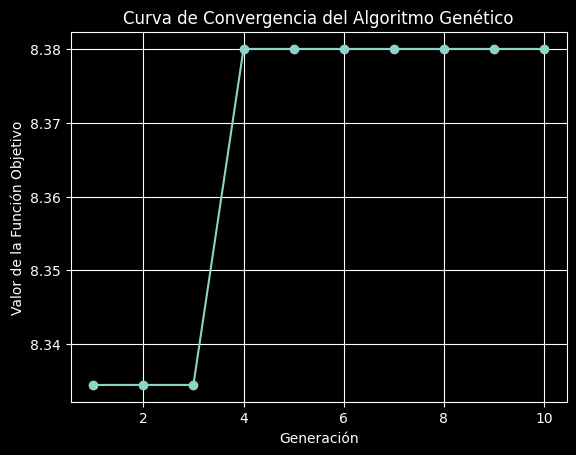

Mejor solución: 1.612903225806452, 3.870967741935484 Aptitud: 8.380020811654527
_________________________________________________________________________________

Generación: 1
Sumatoria de aptitudes total: 24.405411030176897
Mejor individuo: -0.32258064516129004, 12.903225806451612 Aptitud: 7.850364203954215
_________________________________________________________________________________
Generación: 2
Sumatoria de aptitudes total: 26.3783558792924
Mejor individuo: -0.32258064516129004, 12.903225806451612 Aptitud: 7.850364203954215
_________________________________________________________________________________
Generación: 3
Sumatoria de aptitudes total: 29.052653485952135
Mejor individuo: -0.32258064516129004, 12.903225806451612 Aptitud: 7.850364203954215
_________________________________________________________________________________
Generación: 4
Sumatoria de aptitudes total: 30.45369406867846
Mejor individuo: -0.32258064516129004, 12.903225806451612 Aptitud: 7.850364203954215
__

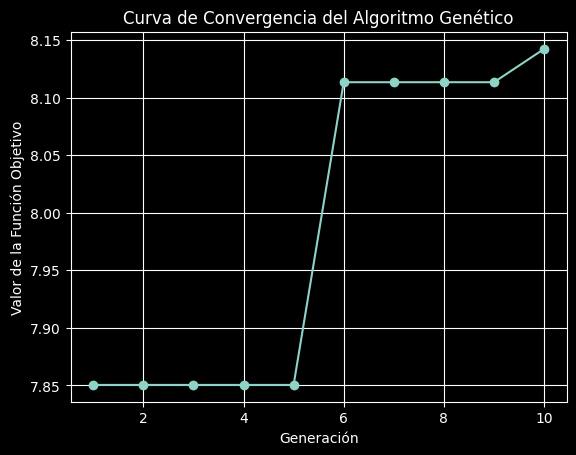

Mejor solución: -1.612903225806452, 8.387096774193548 Aptitud: 8.142351716961498
_________________________________________________________________________________

Generación: 1
Sumatoria de aptitudes total: 24.424973985431844
Mejor individuo: 0.9677419354838701, 5.806451612903226 Aptitud: 8.496982310093653
_________________________________________________________________________________
Generación: 2
Sumatoria de aptitudes total: 32.48158168574402
Mejor individuo: 0.9677419354838701, 5.806451612903226 Aptitud: 8.496982310093653
_________________________________________________________________________________
Generación: 3
Sumatoria de aptitudes total: 33.95920915712799
Mejor individuo: 0.9677419354838701, 5.806451612903226 Aptitud: 8.496982310093653
_________________________________________________________________________________
Generación: 4
Sumatoria de aptitudes total: 33.95920915712799
Mejor individuo: 0.9677419354838701, 5.806451612903226 Aptitud: 8.496982310093653
_____________

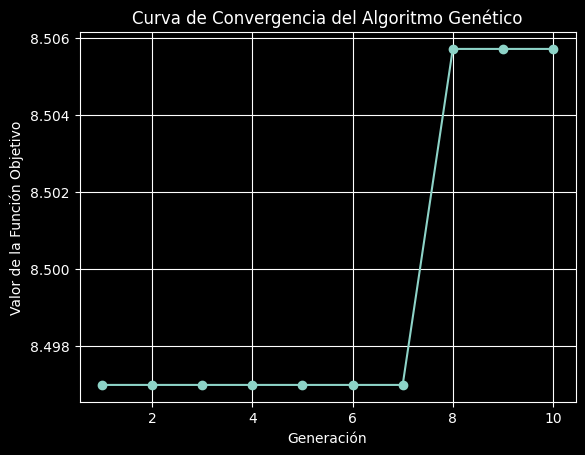

Mejor solución: 0.9677419354838701, 7.096774193548387 Aptitud: 8.505723204994796
_________________________________________________________________________________

Generación: 1
Sumatoria de aptitudes total: 19.63392299687825
Mejor individuo: 4.193548387096774, 0.0 Aptitud: 7.44973985431842
_________________________________________________________________________________
Generación: 2
Sumatoria de aptitudes total: 24.542976066597298
Mejor individuo: 4.193548387096774, 0.0 Aptitud: 7.44973985431842
_________________________________________________________________________________
Generación: 3
Sumatoria de aptitudes total: 26.84953173777316
Mejor individuo: 4.193548387096774, 0.0 Aptitud: 7.44973985431842
_________________________________________________________________________________
Generación: 4
Sumatoria de aptitudes total: 27.129656607700316
Mejor individuo: 4.193548387096774, 2.5806451612903225 Aptitud: 7.835171696149846
____________________________________________________________

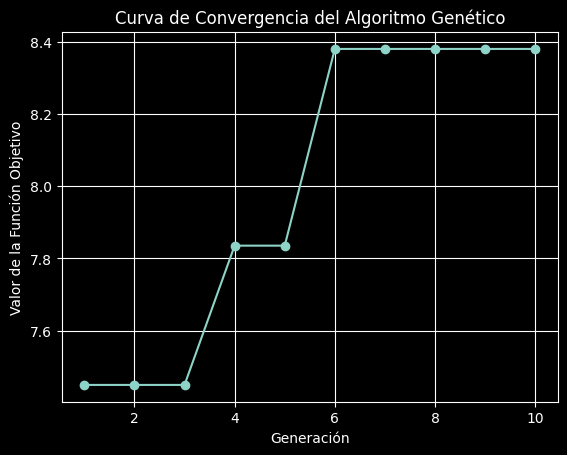

Mejor solución: 2.258064516129032, 4.516129032258065 Aptitud: 8.379604578563997
_________________________________________________________________________________

Generación: 1
Sumatoria de aptitudes total: 21.930905306971905
Mejor individuo: 1.612903225806452, 0.0 Aptitud: 7.811862643080125
_________________________________________________________________________________
Generación: 2
Sumatoria de aptitudes total: 28.821852237252862
Mejor individuo: -0.9677419354838701, 10.96774193548387 Aptitud: 8.070551508844952
_________________________________________________________________________________
Generación: 3
Sumatoria de aptitudes total: 29.88907388137357
Mejor individuo: -0.9677419354838701, 10.32258064516129 Aptitud: 8.144016649323621
_________________________________________________________________________________
Generación: 4
Sumatoria de aptitudes total: 31.729032258064514
Mejor individuo: -0.9677419354838701, 10.32258064516129 Aptitud: 8.144016649323621
________________________

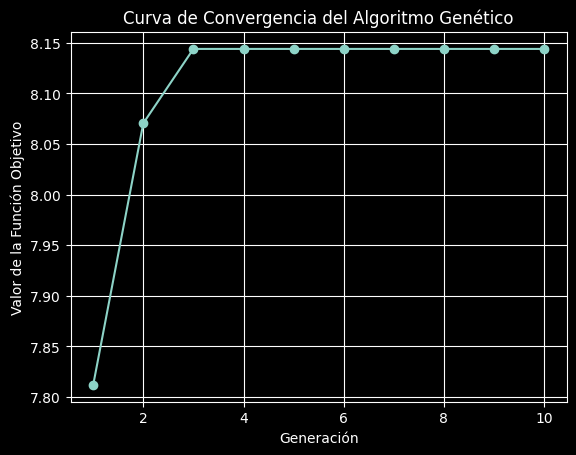

Mejor solución: -0.9677419354838701, 10.32258064516129 Aptitud: 8.144016649323621
_________________________________________________________________________________

Generación: 1
Sumatoria de aptitudes total: 23.745473465140474
Mejor individuo: 0.9677419354838701, 12.258064516129032 Aptitud: 8.007908428720082
_________________________________________________________________________________
Generación: 2
Sumatoria de aptitudes total: 29.59229968782518
Mejor individuo: 0.9677419354838701, 12.258064516129032 Aptitud: 8.007908428720082
_________________________________________________________________________________
Generación: 3
Sumatoria de aptitudes total: 31.05660770031217
Mejor individuo: 0.9677419354838701, 3.870967741935484 Aptitud: 8.383975026014568
_________________________________________________________________________________
Generación: 4
Sumatoria de aptitudes total: 32.40770031217481
Mejor individuo: 0.9677419354838701, 3.870967741935484 Aptitud: 8.383975026014568
__________

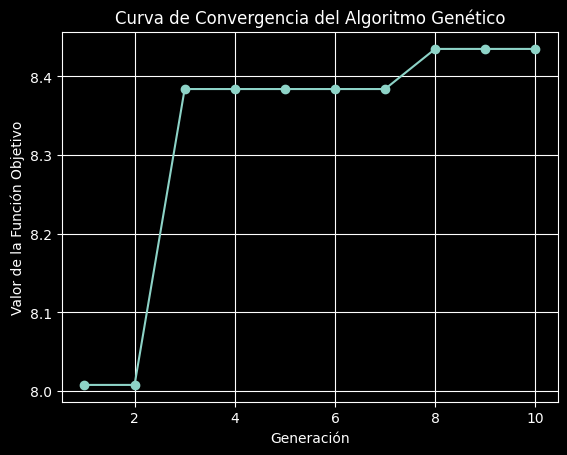

Mejor solución: 0.9677419354838701, 4.516129032258065 Aptitud: 8.43496357960458
_________________________________________________________________________________

Generación: 1
Sumatoria de aptitudes total: 21.050988553590013
Mejor individuo: 6.129032258064516, 5.161290322580645 Aptitud: 7.228928199791883
_________________________________________________________________________________
Generación: 2
Sumatoria de aptitudes total: 24.352757544224765
Mejor individuo: 3.548387096774194, 5.161290322580645 Aptitud: 8.183766909469302
_________________________________________________________________________________
Generación: 3
Sumatoria de aptitudes total: 28.698647242455774
Mejor individuo: 3.548387096774194, 5.161290322580645 Aptitud: 8.183766909469302
_________________________________________________________________________________
Generación: 4
Sumatoria de aptitudes total: 29.2468262226847
Mejor individuo: 0.32258064516129004, 7.741935483870968 Aptitud: 8.469927159209156
_______________

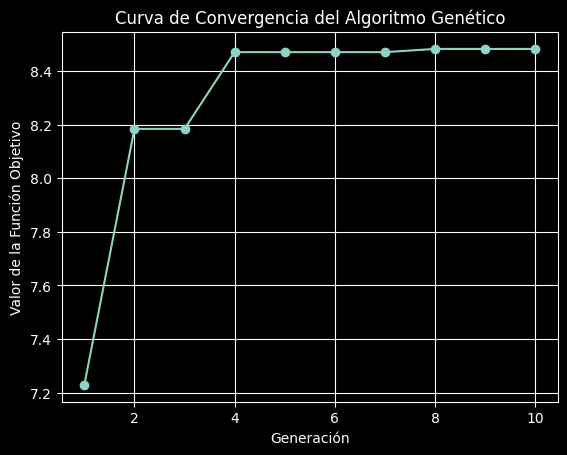

Mejor solución: 0.32258064516129004, 6.451612903225806 Aptitud: 8.48199791883455
_________________________________________________________________________________

Generación: 1
Sumatoria de aptitudes total: 22.473673257023933
Mejor individuo: -2.903225806451613, 7.741935483870968 Aptitud: 7.744640998959419
_________________________________________________________________________________
Generación: 2
Sumatoria de aptitudes total: 29.8738813735692
Mejor individuo: -2.903225806451613, 7.741935483870968 Aptitud: 7.744640998959419
_________________________________________________________________________________
Generación: 3
Sumatoria de aptitudes total: 30.978563995837675
Mejor individuo: -2.903225806451613, 7.741935483870968 Aptitud: 7.744640998959419
_________________________________________________________________________________
Generación: 4
Sumatoria de aptitudes total: 30.978563995837675
Mejor individuo: -2.903225806451613, 7.741935483870968 Aptitud: 7.744640998959419
____________

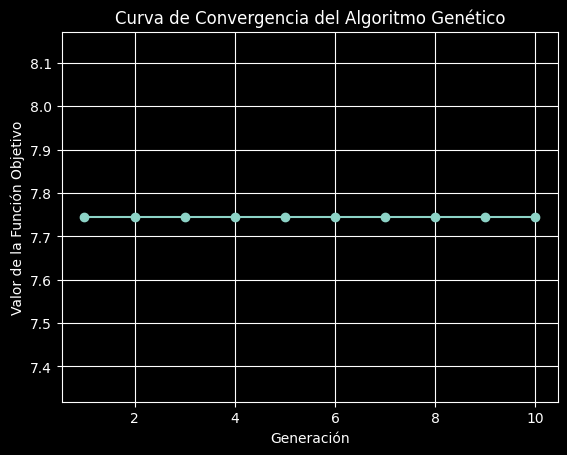

Mejor solución: -2.903225806451613, 7.741935483870968 Aptitud: 7.744640998959419
_________________________________________________________________________________

Generación: 1
Sumatoria de aptitudes total: 26.780020811654524
Mejor individuo: -0.32258064516129004, 6.451612903225806 Aptitud: 8.41436004162331
_________________________________________________________________________________
Generación: 2
Sumatoria de aptitudes total: 31.284703433922996
Mejor individuo: -0.32258064516129004, 6.451612903225806 Aptitud: 8.41436004162331
_________________________________________________________________________________
Generación: 3
Sumatoria de aptitudes total: 32.68262226847035
Mejor individuo: -0.32258064516129004, 6.451612903225806 Aptitud: 8.41436004162331
_________________________________________________________________________________
Generación: 4
Sumatoria de aptitudes total: 33.09365244536941
Mejor individuo: -0.32258064516129004, 6.451612903225806 Aptitud: 8.41436004162331
________

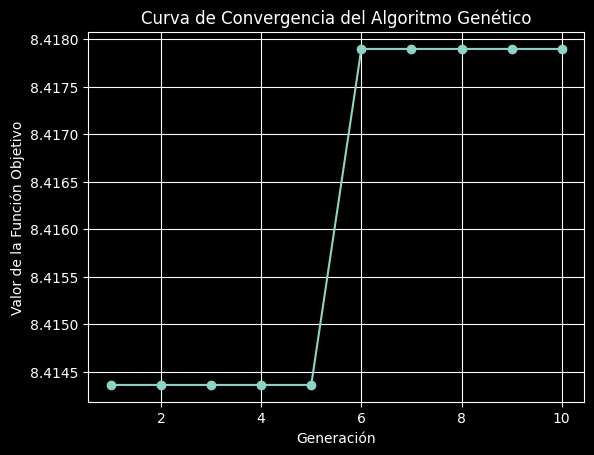

Mejor solución: -0.32258064516129004, 7.096774193548387 Aptitud: 8.417898022892821
_________________________________________________________________________________

Generación: 1
Sumatoria de aptitudes total: 28.670551508844955
Mejor individuo: 0.32258064516129004, 8.387096774193548 Aptitud: 8.44391259105099
_________________________________________________________________________________
Generación: 2
Sumatoria de aptitudes total: 32.49823100936525
Mejor individuo: 0.32258064516129004, 8.387096774193548 Aptitud: 8.44391259105099
_________________________________________________________________________________
Generación: 3
Sumatoria de aptitudes total: 33.186056191467216
Mejor individuo: 0.32258064516129004, 6.451612903225806 Aptitud: 8.48199791883455
_________________________________________________________________________________
Generación: 4
Sumatoria de aptitudes total: 33.83787721123829
Mejor individuo: 0.32258064516129004, 6.451612903225806 Aptitud: 8.48199791883455
__________

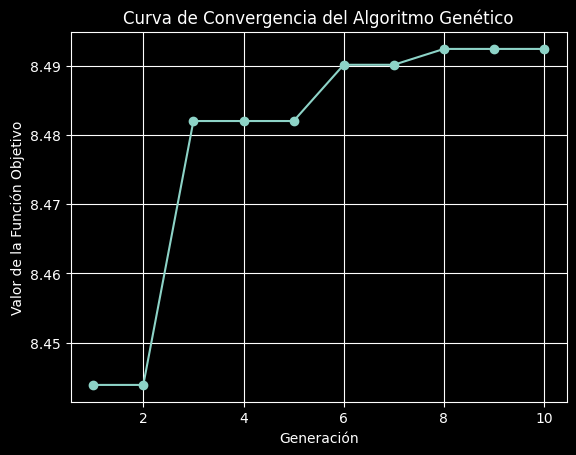

Mejor solución: 1.612903225806452, 6.451612903225806 Aptitud: 8.492403746097814
mejores soluciones:  [8.380020811654527, 8.142351716961498, 8.505723204994796, 8.379604578563997, 8.144016649323621, 8.43496357960458, 8.48199791883455, 7.744640998959419, 8.417898022892821, 8.492403746097814]


In [251]:
mejores_soluciones = []

for i in range(10):
    print("_________________________________________________________________________________")
    print()
    mejor_solucion = algoritmo_genetico(TAMANIO_POBLACION, LONGITUD_CROMOSOMA, TASA_MUTACION, TASA_CRUCE, GENERACIONES)
    print(f"Mejor solución: {binario_a_decimal_x(mejor_solucion[0])}, {binario_a_decimal_y(mejor_solucion[1])}", "Aptitud:", aptitud(mejor_solucion))

    mejores_soluciones.append(aptitud(mejor_solucion))
print("mejores soluciones: ", mejores_soluciones)

##### Torneo

In [252]:
def algoritmo_genetico_torneo(tamanio_poblacion, longitud_cromosoma, tasa_mutacion, tasa_cruce, generaciones):

    poblacion_xy = inicializar_poblacion(tamanio_poblacion, longitud_cromosoma)
    mejor_funcion_objetivo_generaciones = [] # Lista para almacenar la aptitud del mejor individuo y grficar luego

    for generacion in range(generaciones):
        print("Generación:", generacion + 1)

        #  -----------------------------------------------------------------
        # Seleccion de progenitores con el metodo torneo
        progenitores = seleccion_torneo(poblacion_xy)

        #  -----------------------------------------------------------------
        # Cruce
        descendientes = []
        for i in range(0, len(progenitores), 2):
            descendiente1, descendiente2 = cruce_mono_punto(progenitores[i], progenitores[i + 1], tasa_cruce)
            descendientes.extend([descendiente1, descendiente2])
            

        #  -----------------------------------------------------------------
        # Mutacion
        descendientes_mutados = []
        for descendiente in descendientes:
            descendientes_mutados.append(mutacion(descendiente, tasa_mutacion))
            

        # se reemplaza la poblacion con los descendientes mutados
        poblacion = descendientes_mutados

        # se muestra el mejor individuo de la generacion
        mejor_individuo = max(poblacion, key=aptitud)  # Buscar el mínimo para la aptitud
        mejor_funcion_objetivo_generaciones.append(aptitud(mejor_individuo))

        print(f"Mejor individuo: {binario_a_decimal_x(mejor_individuo[0])}, {binario_a_decimal_y(mejor_individuo[1])}", "Aptitud:", aptitud(mejor_individuo))
        print("_________________________________________________________________________________")
    
    # Graficar la evolución de la aptitud
    plt.plot(range(1, generaciones + 1), mejor_funcion_objetivo_generaciones, marker='o')
    plt.xlabel('Generación')
    plt.ylabel('Valor de la Función Objetivo')
    plt.title('Curva de Convergencia del Algoritmo Genético')
    plt.grid(True)
    plt.show()

    return max(poblacion, key=aptitud)  # Retornar el mejor individuo

_________________________________________________________________________________

Generación: 1
Mejor individuo: -2.903225806451613, 10.32258064516129 Aptitud: 7.618938605619146
_________________________________________________________________________________
Generación: 2
Mejor individuo: 3.548387096774194, 11.612903225806452 Aptitud: 7.711342351716961
_________________________________________________________________________________
Generación: 3
Mejor individuo: 0.9677419354838701, 11.612903225806452 Aptitud: 8.11675338189386
_________________________________________________________________________________
Generación: 4
Mejor individuo: 4.193548387096774, 12.258064516129032 Aptitud: 7.382518210197713
_________________________________________________________________________________
Generación: 5
Mejor individuo: 3.548387096774194, 10.32258064516129 Aptitud: 7.912382934443289
_________________________________________________________________________________
Generación: 6
Mejor individu

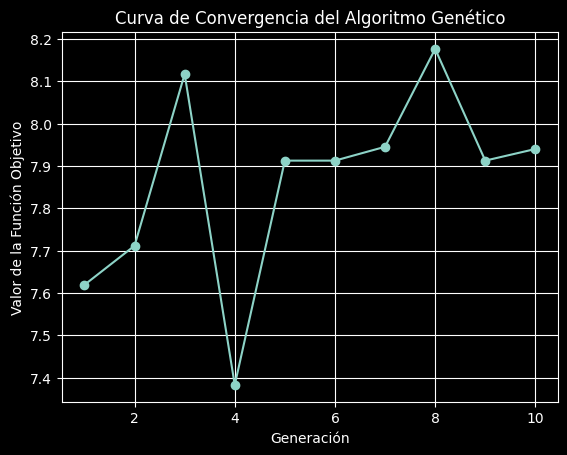

Mejor solución: 1.612903225806452, 0.6451612903225806 Aptitud: 7.939854318418314
_________________________________________________________________________________

Generación: 1
Mejor individuo: 2.258064516129032, 0.6451612903225806 Aptitud: 7.908844953173778
_________________________________________________________________________________
Generación: 2
Mejor individuo: 3.548387096774194, 1.2903225806451613 Aptitud: 7.8278876170655565
_________________________________________________________________________________
Generación: 3
Mejor individuo: 2.903225806451612, 10.32258064516129 Aptitud: 8.070343392299687
_________________________________________________________________________________
Generación: 4
Mejor individuo: 2.258064516129032, 9.67741935483871 Aptitud: 8.261394380853279
_________________________________________________________________________________
Generación: 5
Mejor individuo: 3.548387096774194, 1.935483870967742 Aptitud: 7.920499479708636
_______________________________

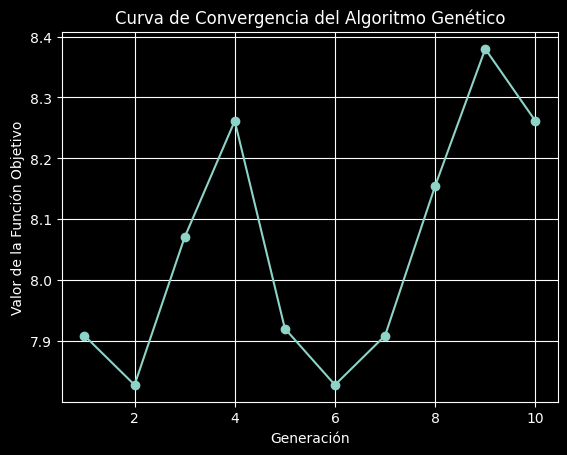

Mejor solución: 2.258064516129032, 9.67741935483871 Aptitud: 8.261394380853279
_________________________________________________________________________________

Generación: 1
Mejor individuo: -3.548387096774194, 13.548387096774194 Aptitud: 6.918418314255984
_________________________________________________________________________________
Generación: 2
Mejor individuo: -8.709677419354838, 8.387096774193548 Aptitud: 3.8316337148803328
_________________________________________________________________________________
Generación: 3
Mejor individuo: 2.903225806451612, 6.451612903225806 Aptitud: 8.336316337148803
_________________________________________________________________________________
Generación: 4
Mejor individuo: -7.419354838709678, 7.096774193548387 Aptitud: 4.95879292403746
_________________________________________________________________________________
Generación: 5
Mejor individuo: -8.709677419354838, 16.129032258064516 Aptitud: 2.9700312174817904
____________________________

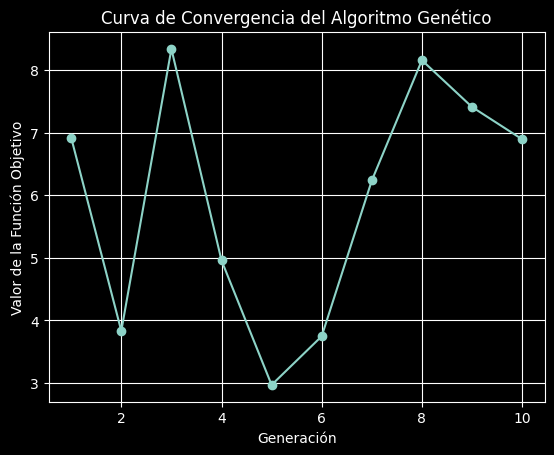

Mejor solución: 0.32258064516129004, 16.774193548387096 Aptitud: 6.893652445369407
_________________________________________________________________________________

Generación: 1
Mejor individuo: 3.548387096774194, 0.6451612903225806 Aptitud: 7.721956295525495
_________________________________________________________________________________
Generación: 2
Mejor individuo: 4.838709677419354, 1.935483870967742 Aptitud: 7.555463059313216
_________________________________________________________________________________
Generación: 3
Mejor individuo: 4.838709677419354, 1.935483870967742 Aptitud: 7.555463059313216
_________________________________________________________________________________
Generación: 4
Mejor individuo: 4.193548387096774, 1.935483870967742 Aptitud: 7.758792924037463
_________________________________________________________________________________
Generación: 5
Mejor individuo: 4.193548387096774, 1.935483870967742 Aptitud: 7.758792924037463
______________________________

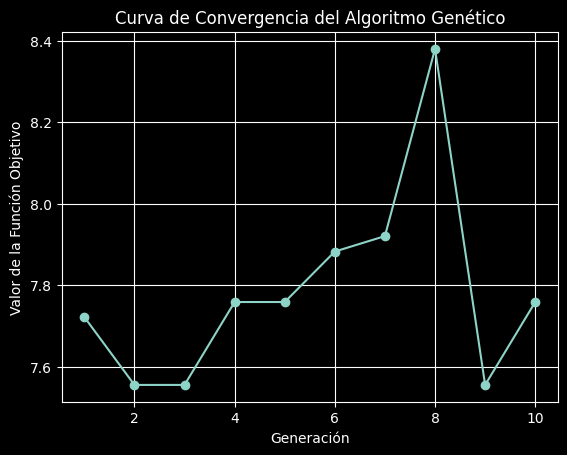

Mejor solución: 4.193548387096774, 1.935483870967742 Aptitud: 7.758792924037463
_________________________________________________________________________________

Generación: 1
Mejor individuo: 0.9677419354838701, 6.451612903225806 Aptitud: 8.508012486992715
_________________________________________________________________________________
Generación: 2
Mejor individuo: 0.9677419354838701, 16.774193548387096 Aptitud: 6.873048907388137
_________________________________________________________________________________
Generación: 3
Mejor individuo: 0.9677419354838701, 11.612903225806452 Aptitud: 8.11675338189386
_________________________________________________________________________________
Generación: 4
Mejor individuo: 0.9677419354838701, 16.774193548387096 Aptitud: 6.873048907388137
_________________________________________________________________________________
Generación: 5
Mejor individuo: 0.9677419354838701, 12.258064516129032 Aptitud: 8.007908428720082
__________________________

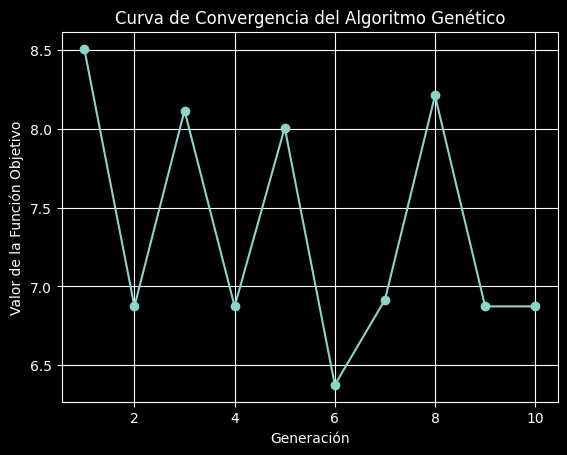

Mejor solución: 0.9677419354838701, 16.774193548387096 Aptitud: 6.873048907388137
_________________________________________________________________________________

Generación: 1
Mejor individuo: 3.548387096774194, 11.612903225806452 Aptitud: 7.711342351716961
_________________________________________________________________________________
Generación: 2
Mejor individuo: 3.548387096774194, 3.870967741935484 Aptitud: 8.118418314255981
_________________________________________________________________________________
Generación: 3
Mejor individuo: 3.548387096774194, 1.2903225806451613 Aptitud: 7.8278876170655565
_________________________________________________________________________________
Generación: 4
Mejor individuo: 0.9677419354838701, 1.2903225806451613 Aptitud: 8.046826222684702
_________________________________________________________________________________
Generación: 5
Mejor individuo: 3.548387096774194, 3.870967741935484 Aptitud: 8.118418314255981
___________________________

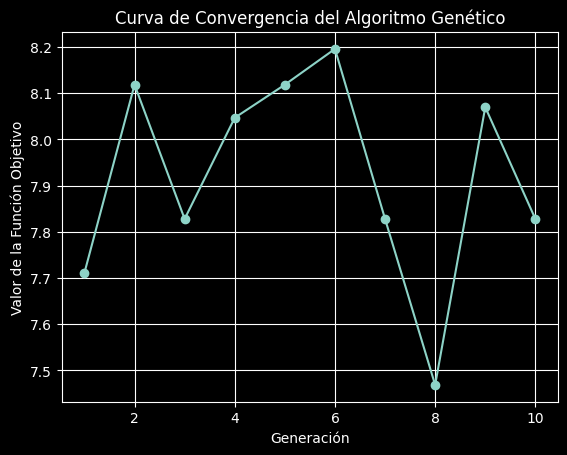

Mejor solución: 3.548387096774194, 1.2903225806451613 Aptitud: 7.8278876170655565
_________________________________________________________________________________

Generación: 1
Mejor individuo: 0.32258064516129004, 13.548387096774194 Aptitud: 7.756295525494276
_________________________________________________________________________________
Generación: 2
Mejor individuo: 2.258064516129032, 13.548387096774194 Aptitud: 7.613319458896982
_________________________________________________________________________________
Generación: 3
Mejor individuo: 1.612903225806452, 13.548387096774194 Aptitud: 7.702601456815817
_________________________________________________________________________________
Generación: 4
Mejor individuo: 4.193548387096774, 2.5806451612903225 Aptitud: 7.835171696149846
_________________________________________________________________________________
Generación: 5
Mejor individuo: 2.258064516129032, 0.6451612903225806 Aptitud: 7.908844953173778
_________________________

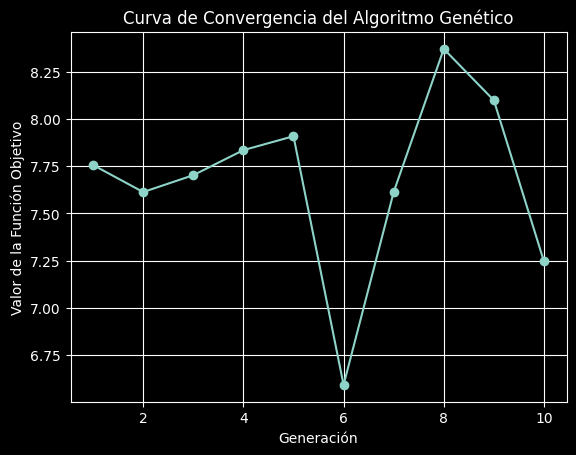

Mejor solución: 4.193548387096774, 12.903225806451612 Aptitud: 7.2457856399583775
_________________________________________________________________________________

Generación: 1
Mejor individuo: -1.612903225806452, 10.96774193548387 Aptitud: 7.94006243496358
_________________________________________________________________________________
Generación: 2
Mejor individuo: -1.612903225806452, 12.258064516129032 Aptitud: 7.759001040582725
_________________________________________________________________________________
Generación: 3
Mejor individuo: -0.9677419354838701, 10.96774193548387 Aptitud: 8.070551508844952
_________________________________________________________________________________
Generación: 4
Mejor individuo: -0.32258064516129004, 10.96774193548387 Aptitud: 8.159417273673258
_________________________________________________________________________________
Generación: 5
Mejor individuo: -0.9677419354838701, 5.806451612903226 Aptitud: 8.285327783558792
_______________________

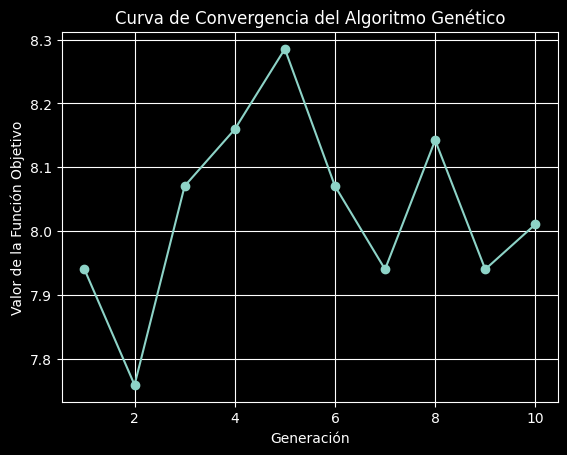

Mejor solución: -1.612903225806452, 10.32258064516129 Aptitud: 8.010613943808531
_________________________________________________________________________________

Generación: 1
Mejor individuo: 4.193548387096774, 6.451612903225806 Aptitud: 8.013735691987517
_________________________________________________________________________________
Generación: 2
Mejor individuo: 2.258064516129032, 7.741935483870968 Aptitud: 8.405619146722165
_________________________________________________________________________________
Generación: 3
Mejor individuo: 2.258064516129032, 9.67741935483871 Aptitud: 8.261394380853279
_________________________________________________________________________________
Generación: 4
Mejor individuo: 4.193548387096774, 7.741935483870968 Aptitud: 7.9667013527575445
_________________________________________________________________________________
Generación: 5
Mejor individuo: 4.193548387096774, 4.516129032258065 Aptitud: 7.984391259105101
_________________________________

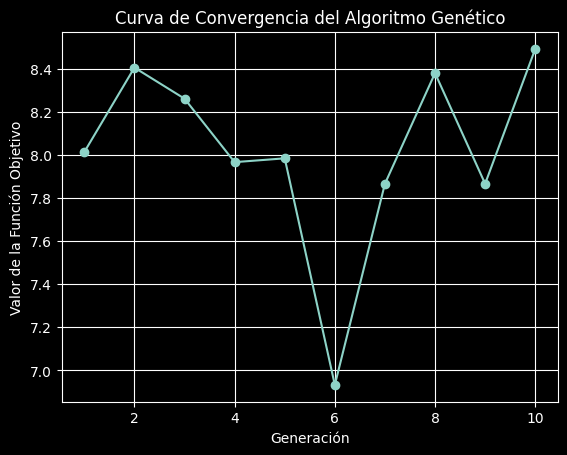

Mejor solución: 1.612903225806452, 6.451612903225806 Aptitud: 8.492403746097814
_________________________________________________________________________________

Generación: 1
Mejor individuo: 2.258064516129032, 7.096774193548387 Aptitud: 8.427055150884495
_________________________________________________________________________________
Generación: 2
Mejor individuo: 1.612903225806452, 5.161290322580645 Aptitud: 8.462851196670135
_________________________________________________________________________________
Generación: 3
Mejor individuo: 1.612903225806452, 7.096774193548387 Aptitud: 8.487200832466181
_________________________________________________________________________________
Generación: 4
Mejor individuo: 0.32258064516129004, 7.096774193548387 Aptitud: 8.482622268470342
_________________________________________________________________________________
Generación: 5
Mejor individuo: 2.258064516129032, 7.096774193548387 Aptitud: 8.427055150884495
________________________________

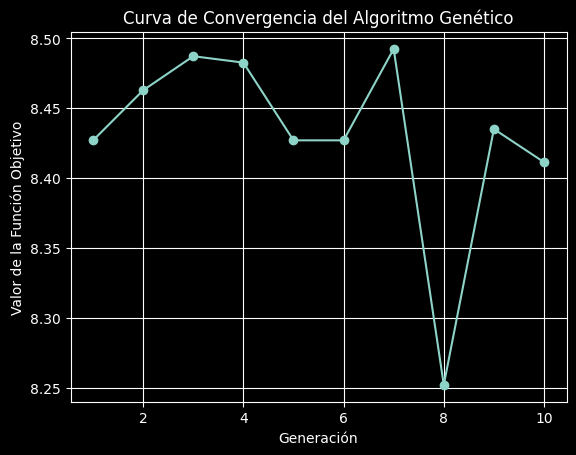

Mejor solución: 2.258064516129032, 5.161290322580645 Aptitud: 8.411446409989594
mejores soluciones:  [7.939854318418314, 8.261394380853279, 6.893652445369407, 7.758792924037463, 6.873048907388137, 7.8278876170655565, 7.2457856399583775, 8.010613943808531, 8.492403746097814, 8.411446409989594]


In [253]:
mejores_soluciones = []

for i in range(10):
    print("_________________________________________________________________________________")
    print()
    mejor_solucion = algoritmo_genetico_torneo(TAMANIO_POBLACION, LONGITUD_CROMOSOMA, TASA_MUTACION, TASA_CRUCE, GENERACIONES)
    print(f"Mejor solución: {binario_a_decimal_x(mejor_solucion[0])}, {binario_a_decimal_y(mejor_solucion[1])}", "Aptitud:", aptitud(mejor_solucion))

    mejores_soluciones.append(aptitud(mejor_solucion))
print("mejores soluciones: ", mejores_soluciones)

Valor maximo:  8.508641975308644
Valor maximo ruleta:  8.482622268470342
Valor maximo torneo:  8.496982310093653


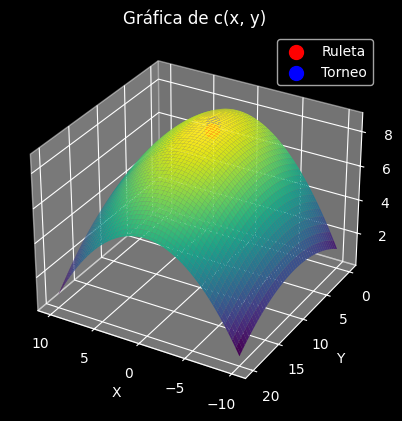

In [254]:
# Define la función c(x, y)
def c(x, y):
    return 7.7 + 0.15 * x + 0.22 * y - 0.05 * (x ** 2) - 0.016 * (y ** 2) - 0.007 * x * y

# Intervalos de las variables independientes
x = np.linspace(-10, 10, 100)
y = np.linspace(0, 20, 100)
X, Y = np.meshgrid(x, y)
Z = c(X, Y)

# Encuentra el valor máximo y sus coordenadas
max_val = np.max(Z)
max_pos = np.unravel_index(np.argmax(Z), Z.shape)
max_x, max_y = X[max_pos], Y[max_pos]


# Configuración de la gráfica
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

# Agrega los puntos de máximo en rojo y azul
# Suponiendo que estos son los puntos de máximo encontrados por tu algoritmo
point_ruleta_x = 0.32258064516129004  # Ejemplo de punto encontrado por ruleta
point_ruleta_y = 7.096774193548387
point_torneo_x = 0.9677419354838701  # Ejemplo de punto encontrado por torneo
point_torneo_y = 5.806451612903226 

# Calcula los valores Z para estos puntos
point_ruleta_z = c(point_ruleta_x, point_ruleta_y)
point_torneo_z = c(point_torneo_x, point_torneo_y)

print("Valor maximo: ", max_val)
print("Valor maximo ruleta: ", point_ruleta_z)
print("Valor maximo torneo: ", point_torneo_z)

# Agrega los puntos a la gráfica
ax.scatter(point_ruleta_x, point_ruleta_y, point_ruleta_z, color='red', label='Ruleta', s=100)
ax.scatter(point_torneo_x, point_torneo_y, point_torneo_z, color='blue', label='Torneo', s=100)


# Etiquetas y título
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('c(x, y)')
ax.set_title('Gráfica de c(x, y)')
ax.legend()

# Rotar el gráfico antes de mostrarlo
ax.view_init(elev=30, azim=120)  # Ajusta estos valores para cambiar la vista

# Muestra la gráfica
plt.show()